In [44]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf
import keras as keras
plt.style.use('ggplot')

In [45]:
codes = {}
codes['US'] = 'USGG10YR'
codes['Germany'] = 'GDBR10'
codes['UK'] = 'GUKG10'
codes['France'] = 'GFRN10'
codes['Australia'] = 'GACGB10'
codes['Canada'] = 'GCAN10YR'
codes['New Zealand'] = 'GNZGB10'
codes['Japan'] = 'JGBS10'
codes['Switzerland'] = 'GSWISS10'
codes['Norway'] = 'GNOR10YR'
codes['Italy'] = 'GBTPGR10'

sheet_names = pd.ExcelFile('G10_RV.xlsx').sheet_names[:11]
dfs = {x: pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']].rename(columns={'Last Price': x}) for x in sheet_names}
df = pd.DataFrame({'Date': dfs[sheet_names[0]]['Date']})  

for key in dfs:
    df = pd.merge(df, dfs[key], on='Date', how='outer')

df = df.set_index('Date').resample('D').asfreq().ffill().dropna()
df.iloc[[0,-1],:]

,USGG10YR,GDBR10,GUKG10,GFRN10,GACGB10,GCAN10YR,GNZGB10,JGBS10,GSWISS10,GNOR10YR,GBTPGR10
Date,,,,,,,,,,,
2010-01-05,3.7608,3.373,4.016,3.592,5.621,3.565,5.843,1.329,2.009,4.147,4.101
2024-04-12,4.5216,2.359,4.137,2.865,4.266,3.649,4.839,0.864,0.739,3.707,3.762


In [46]:
def predictor(method, target, t):

    data = df.copy()
    target = codes[target]
    target_t = f'{target}_{t}'
    ts = [1,5,10,25,50,100]

    for x in data:
        for z in ts:
            data[f'{x}_{z}'] = df[x].diff(z)

    data = data.dropna()
    cutoff = '2020-1-1'
    training = data[data.index < cutoff]
    testing = data[data.index > cutoff]

    if method == 'simple' or method == 'multi':
        if method == 'simple':
            training_X = training[[x for x in training if x.endswith(f'_{t}') and not x.startswith(target)]]
            training_y = training[target_t]
            testing_X = testing[[x for x in testing if x.endswith(f'_{t}') and not x.startswith(target)]]
            testing_y = testing[target_t]
        if method == 'multi':
            training_X = training[[x for x in training if '_' in x and x != target_t]]
            training_y = training[target_t]
            testing_X = testing[[x for x in testing if '_' in x and x != target_t]]
            testing_y = testing[target_t]
    
        model = LinearRegression()
        model.fit(training_X, training_y)
        training_prediction = model.predict(training_X)
        testing_prediction = model.predict(testing_X)
        training_accuracy = round(r2_score(training_y, training_prediction), 2)
        testing_accuracy = round(r2_score(testing_y, testing_prediction), 2)
        prediction = pd.DataFrame(testing[target].copy())
        prediction['c_prediction'] = testing_prediction
        prediction['prediction'] = prediction[target].shift(t) + prediction['c_prediction']
        prediction = prediction[[target, 'prediction']].dropna()
        return prediction, training_accuracy, testing_accuracy
    
    elif method == 'neural':
        training_X = training[[x for x in training if '_' in x and x != target_t]]
        training_y = training[target_t]
        testing_X = testing[[x for x in testing if '_' in x and x != target_t]]
        testing_y = testing[target_t]
        scaler = StandardScaler()
        training_X = scaler.fit_transform(training_X)
        testing_X = scaler.transform(testing_X)
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(training_X.shape[1], activation='relu', input_shape=[training_X.shape[1]]),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(training_X.shape[1] / 2, activation='relu'),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        model.fit(training_X, training_y, epochs=200, validation_split=0.2, callbacks=[early_stopping])
        training_prediction = model.predict(training_X)
        testing_prediction = model.predict(testing_X)
        training_accuracy = round(r2_score(training_y, training_prediction), 2)
        testing_accuracy = round(r2_score(testing_y, testing_prediction), 2)
        prediction = pd.DataFrame(testing[target].copy())
        prediction['c_prediction'] = testing_prediction
        prediction['prediction'] = prediction[target].shift(t) + prediction['c_prediction']
        prediction = prediction[[target, 'prediction']].dropna()
        return prediction, training_accuracy, testing_accuracy

def performance(t):
    performances = pd.DataFrame()
    performances['Country'] = codes.keys()
    performances['r2: Simple'] = performances['Country'].apply(lambda x: predictor('simple', x, t)[2])
    performances['r2: Multi'] = performances['Country'].apply(lambda x: predictor('multi', x, t)[2])
    performances['r2: Neural'] = performances['Country'].apply(lambda x: predictor('neural', x, t)[2])
    performances = performances.set_index('Country')
    simple_mean = round(performances['r2: Simple'].mean(), 2)
    multi_mean = round(performances['r2: Multi'].mean(), 2)
    nn_mean = round(performances['r2: Neural'].mean(), 2)
    performances.loc['Mean'] = {'r2: Simple': simple_mean, 'r2: Multi': multi_mean, 'r2: Neural': nn_mean}
    return performances

performance(10)

Epoch 1/200
89/89 [==============================] - 0s 1ms/step - loss: 0.5955 - val_loss: 0.0351
Epoch 2/200
89/89 [==============================] - 0s 762us/step - loss: 0.1288 - val_loss: 0.0194
Epoch 3/200
89/89 [==============================] - 0s 743us/step - loss: 0.0711 - val_loss: 0.0106
Epoch 4/200
89/89 [==============================] - 0s 754us/step - loss: 0.0451 - val_loss: 0.0097
Epoch 5/200
89/89 [==============================] - 0s 723us/step - loss: 0.0311 - val_loss: 0.0079
Epoch 6/200
89/89 [==============================] - 0s 726us/step - loss: 0.0241 - val_loss: 0.0070
Epoch 7/200
89/89 [==============================] - 0s 736us/step - loss: 0.0201 - val_loss: 0.0067
Epoch 8/200
89/89 [==============================] - 0s 726us/step - loss: 0.0180 - val_loss: 0.0062
Epoch 9/200
89/89 [==============================] - 0s 737us/step - loss: 0.0155 - val_loss: 0.0060
Epoch 10/200
89/89 [==============================] - 0s 781us/step - loss: 0.0145 - val_loss

,r2: Simple,r2: Multi,r2: Neural
Country,,,
US,0.80,0.93,0.88
Germany,0.92,0.96,0.93
UK,0.64,0.88,0.83
France,0.97,0.98,0.95
Australia,0.74,0.88,0.81
Canada,0.77,0.91,0.87
New Zealand,0.66,0.85,0.80
Japan,0.17,0.67,0.63
Switzerland,0.70,0.87,0.81


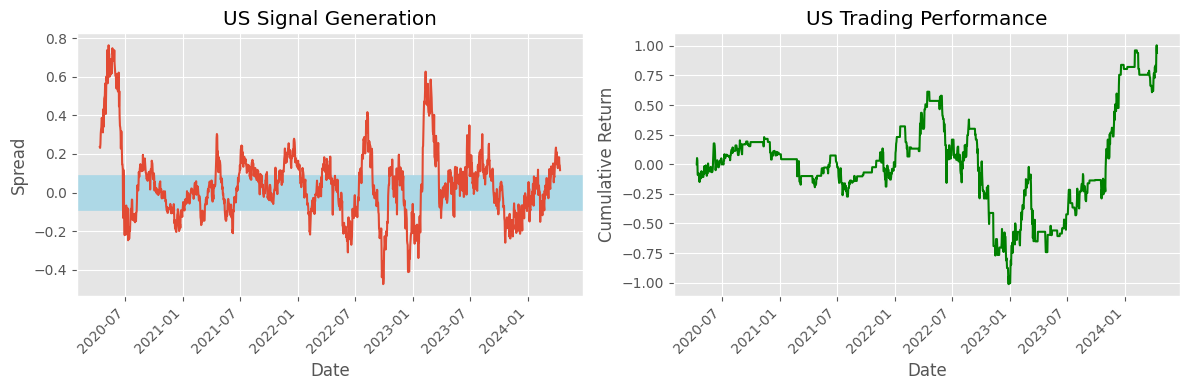

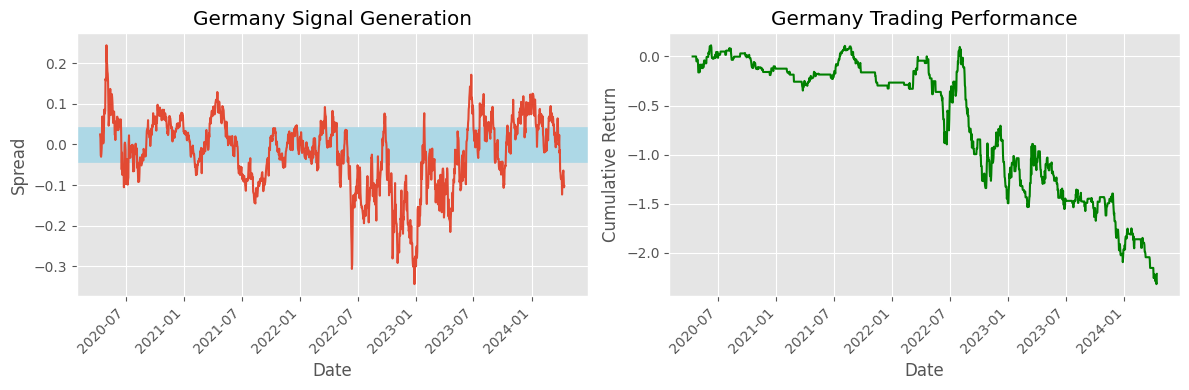

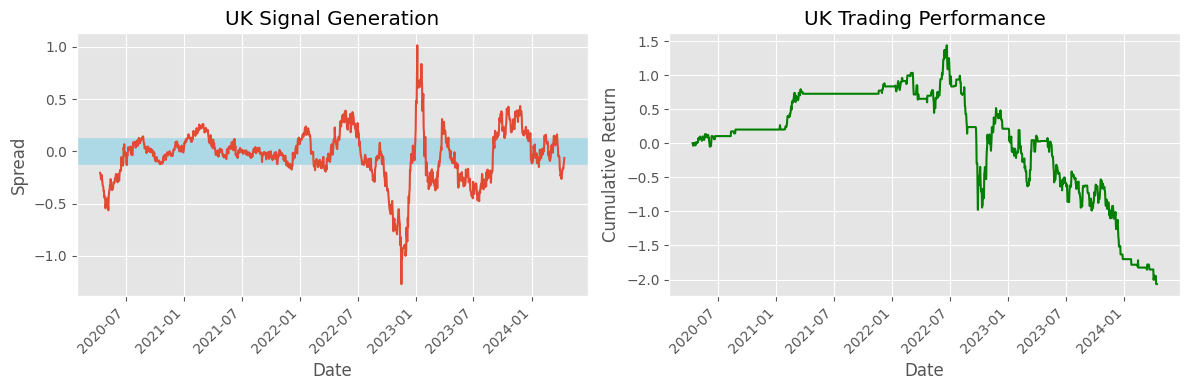

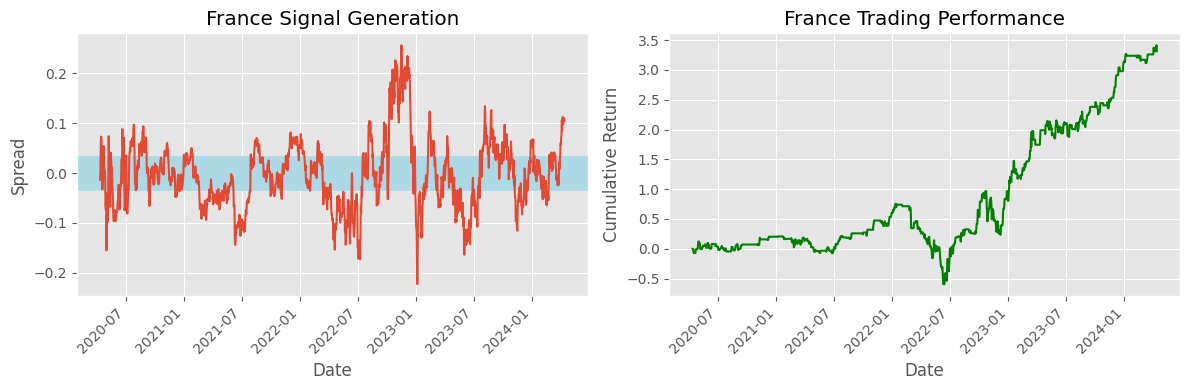

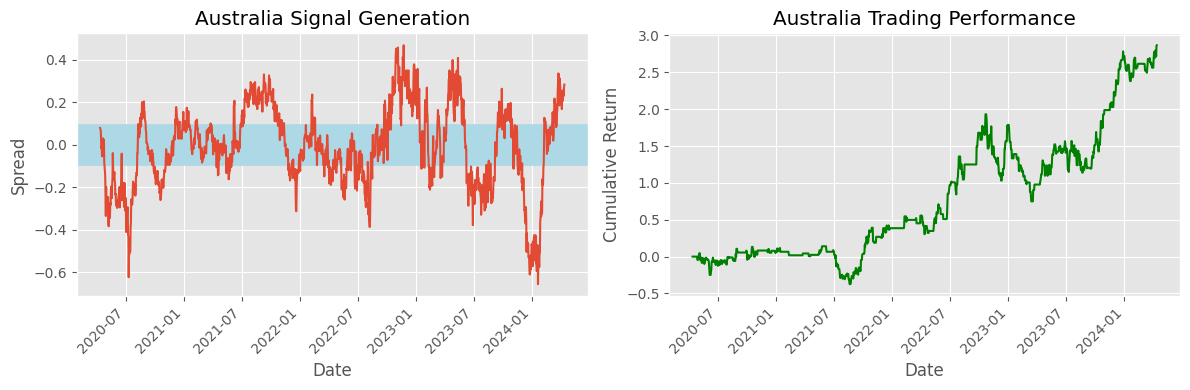

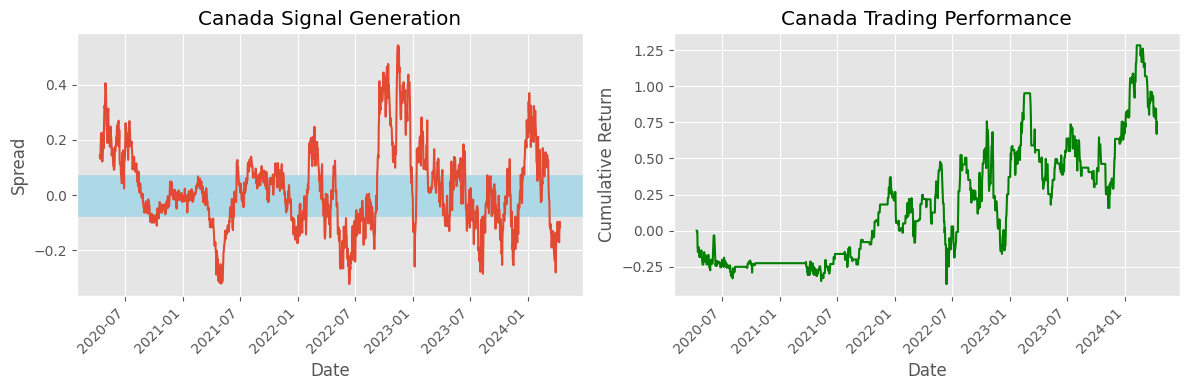

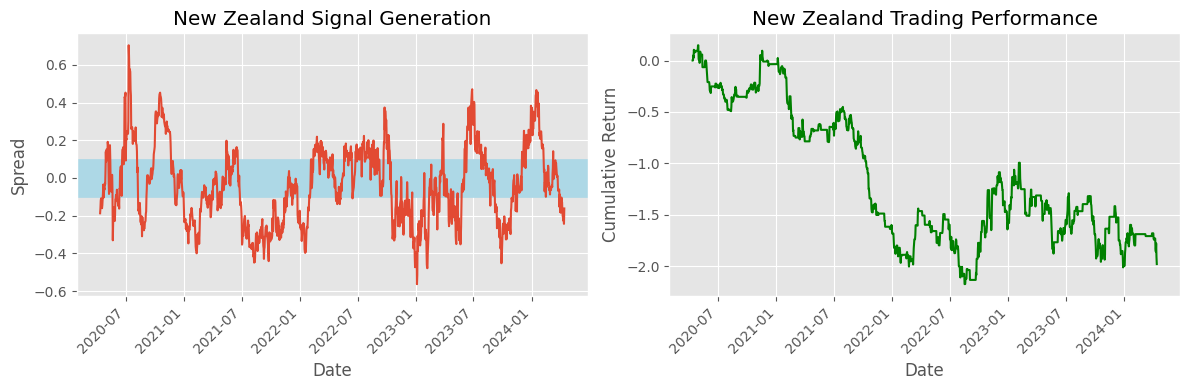

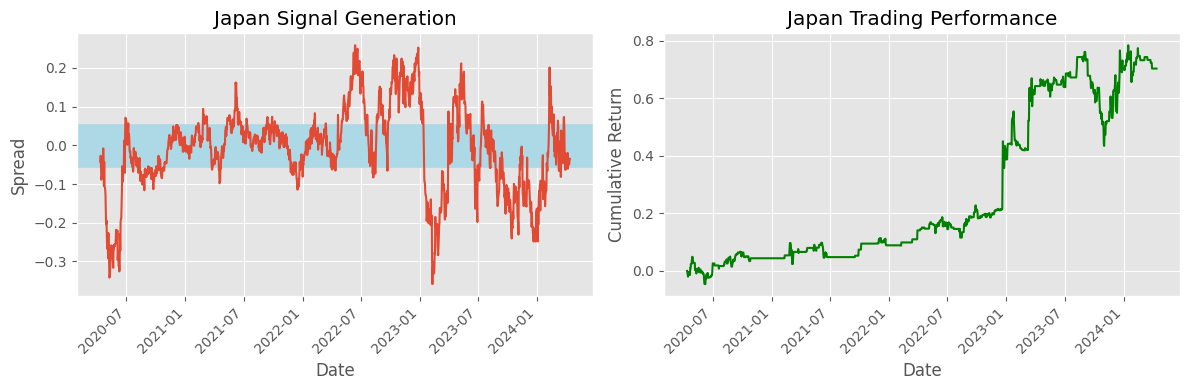

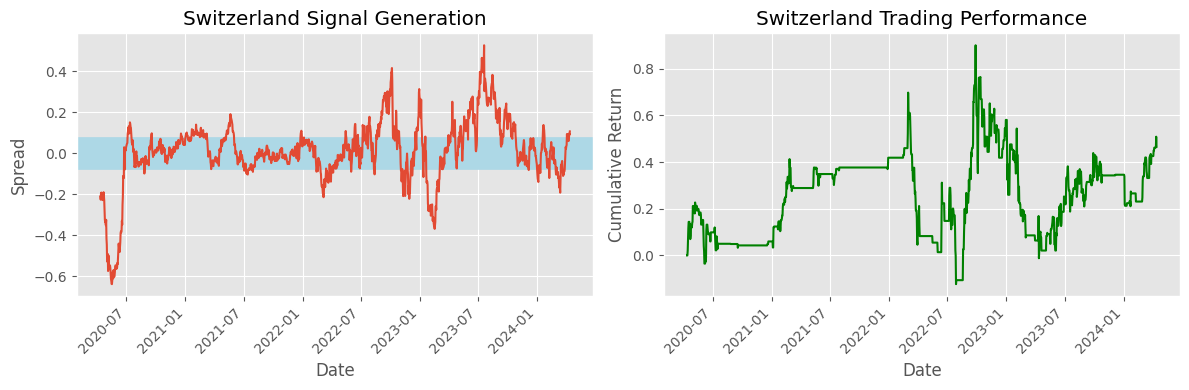

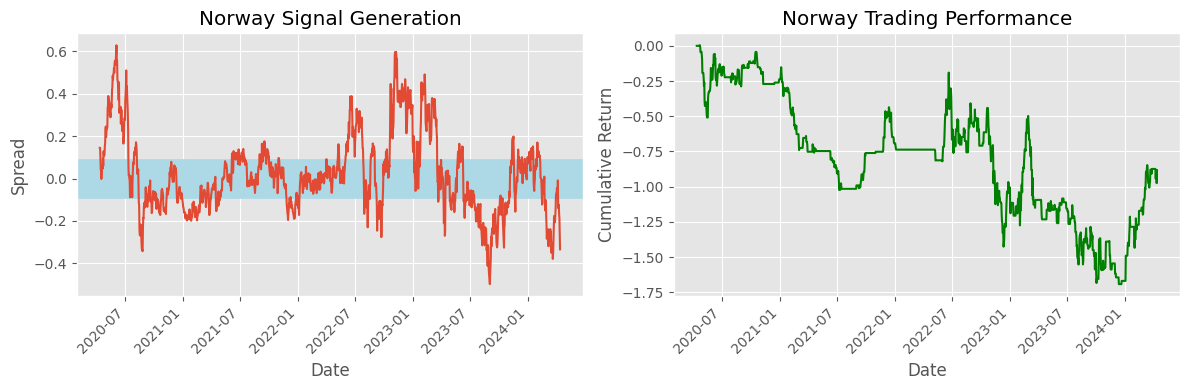

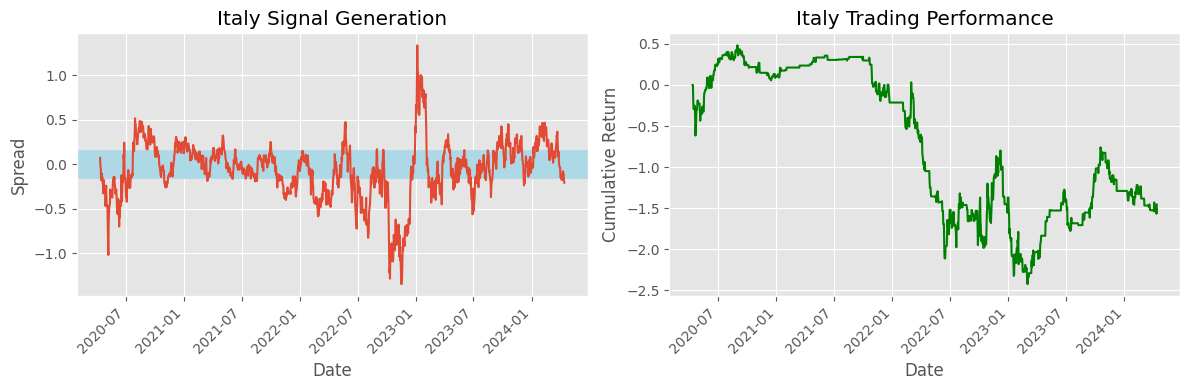

In [47]:
def trader(target, t, std):
    data = predictor('multi', target, t)[0]
    name = target
    target = codes[target]
    data['spread'] = data['prediction'] - data[target]
    threshold = data['spread'].std() * std
    data['signal'] = 0
    data.loc[data[target] > data['prediction'] + threshold , 'signal'] = -1
    data.loc[data[target] < data['prediction'] - threshold, 'signal'] = 1
    data['return'] = data[target].diff(1)
    data['signal_return'] = data['return'] * data['signal']
    data['cum_return'] = data['signal_return'].cumsum()

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(data.index, data['spread'], label='Spread')
    axs[0].axhspan(-threshold, threshold, color='lightblue', alpha=1)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Spread')
    axs[0].set_title(f'{name} Signal Generation')

    axs[1].plot(data.index, data['cum_return'], label='Cumulative Return', color='green')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Cumulative Return')
    axs[1].set_title(f'{name} Trading Performance')

    date_format = DateFormatter('%Y-%m')
    axs[0].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    plt.show()

for country in codes.keys():
    trader(country, 100, .5)